In [1]:
import pandas as pd 
import numpy as np 
import gc
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns 

In [2]:
def trim_categories(df, cols_list):
    for col in cols_list:
        df[col].cat.rename_categories(df[col].cat.categories.astype('str').str.strip(), inplace=True)

### Import data, setting dtype to save memory

In [3]:
levels_keep_cols = ['TankId', 'TankLevelPercent', 'TankLevelGallons', 'ExactFuelEventId']
levels_col_types = {'TankId': 'category',
             'ExactFuelEventId': 'uint64',
             'TankLevelPercent': 'float32',
             'TankLevelGallons': 'float32'}
#Rows with TankId == '2' are dropped on read-in, after being manually identified
levels_fueltank_df = pd.read_csv('data/Extranet2.ExactFuelTankLevels.csv', 
                                 skiprows=[48671, 1824800, 4579415, 5656381],
                                 usecols = levels_keep_cols, 
                                 dtype=levels_col_types ).drop(
    ['TankId'], axis=1)

#levels_fueltank_df = levels_fueltank_df.set_index('ExactFuelEventId').drop(['TankId'], axis=1)

#### Fuel Optimization data; only need tank capacity

In [4]:
optimization_fuel_df = pd.read_csv('data/BGEIDSC.EF2EFFP.csv',
                                   dtype={'TANKCAP': 'uint16', 'TRUCK' : 'category'},
                                  usecols = ['TRUCK', 'TANKCAP'])
optimization_fuel_df.columns = [s.lower() for s in optimization_fuel_df.columns]
trim_categories(optimization_fuel_df, ['truck'])

In [5]:
optimization_fuel_df.truck.cat.categories

Index(['1', '243', '244', '245', '246', '274', '301', '302', '303', '304',
       ...
       '2168', '2169', '2170', '2171', '2172', '2173', '2174', '2175', '2176',
       '9999'],
      dtype='object', length=836)

In [6]:

#optimization_fuel_df.set_index('truck', inplace=True)

In [7]:
units_df = pd.read_csv('data/IBGEFILE.UNITS.csv', 
                       dtype = {'UNMAKE': 'category', 
                               'UNUNIT': 'category'})

units_df.columns = ['unit_number', 'model_year', 'make'] 

#Can drop non-int units
#units_df.unit_number = pd.to_numeric(units_df.unit_number, errors = 'coerce')
#units_df = units_df[units_df.unit_number != 1].dropna()
#Make units category variable
#units_df['unit_number'] = units_df.unit_number.astype('category')


# Trim white space from category strings 
trim_categories(units_df, ['make', 'unit_number'])

# Remove invalid entries
units_df = units_df[units_df.unit_number.isin(['ZEBE', 'CCTRK', 'BGXL', '1']) == False]

# Fix typos
units_df.make[units_df.make.isin(['KENOWRTH', 'KEWORTH'])] = 'KENWORTH'

In [8]:
units_df.unit_number.cat.categories

Index(['1', '121', '1505', '1506', '1507', '1508', '1509', '1510', '1511',
       '1512',
       ...
       '535', '536', '537', '538', '539', '540', '816', 'BGXL', 'CCTRK',
       'ZEBE'],
      dtype='object', length=708)

In [9]:
units_df.make.cat.categories

Index(['', 'FREIGHTLINER', 'KENOWRTH', 'KENWORTH', 'KEWORTH', 'MACK',
       'PETERBILT', 'SYSTEM TEST', 'VOLVO'],
      dtype='object')

In [10]:
units_df.make.value_counts()

KENWORTH        526
VOLVO           139
FREIGHTLINER     15
PETERBILT        14
MACK             10
SYSTEM TEST       0
KEWORTH           0
KENOWRTH          0
                  0
Name: make, dtype: int64

In [11]:
transaction_df_cols = ['tr_id', 'tr_date', 'tr_time', 'tr_station_id', 'tr_station_name',
                         'tr_station_cty', 'tr_station_st', 'tr_drvr_code', 'tr_unit_id', 
                         'tr_item_cd1', 'tr_item_qty1', 'tr_item_cd2', 'tr_item_qty2',
                          'tr_item_cd3', 'tr_item_qty3', 'tr_item_cd4', 'tr_item_qty4',
                          'tr_item_cd5', 'tr_item_qty5', 'tr_item_cd6', 'tr_item_qty6']
tr_dtypes= {'tr_id' : 'uint32',  
            'tr_date' : 'uint32', 
            'tr_time' : 'uint32', 
            'tr_station_id' : 'category', 
            'tr_station_name' : 'category', 
            'tr_station_cty' : 'category', 
            'tr_station_st' : 'category', 
            'tr_drvr_code' : 'category', 
            'tr_unit_id' : 'category', 
            'tr_item_cd1' : 'category', 
            'tr_item_qty1' : 'float32', 
            'tr_item_cd2' : 'category', 
            'tr_item_qty2' : 'float32', 
            'tr_item_cd3' : 'category', 
            'tr_item_qty3' : 'float32', 
            'tr_item_cd4' : 'category', 
            'tr_item_qty4' : 'float32', 
            'tr_item_cd5' : 'category', 
            'tr_item_qty5' : 'float32', 
            'tr_item_cd6' : 'category', 
            'tr_item_qty6' : 'float32'}
act_fuel_transactions = ['ULSD', 'FUEL', 'CDSL', 'DSL1', 'BDSL']
transaction_df = pd.read_csv('data/BGETCHDATA.PTCHTRANH.csv', names = transaction_df_cols, dtype = tr_dtypes, header=0 )

# Trim white space from category strings 
trim_categories(transaction_df, ['tr_station_id', 'tr_station_name',
                         'tr_station_cty', 'tr_station_st','tr_drvr_code','tr_unit_id','tr_item_cd1', 'tr_item_cd2', 'tr_item_cd3', 'tr_item_cd4', 'tr_item_cd5', 'tr_item_cd6' ])

#### Create datetime column in transactions_df

In [12]:
#confirm no junk data in this col (returns false if no NaNs)
None in transaction_df.tr_time

# 20170112 3

#Combine tr_date and tr_time into a single date time column
    #1. zero pad tr_time on left for interpretation as military time
        #cast tr_time as string
transaction_df.tr_time = transaction_df.tr_time.astype(str)

# 20170112 '3' Time column is now a string
#ensure none of my strings are over 4 digits in length
for s in transaction_df.tr_time:
    assert len(s) < 5

#check for blanks
'' in transaction_df.tr_time

#add zeros to the left until each cell is len 4
zero_padded_time = []
for s in transaction_df.tr_time:
    while len(s) < 4:
        s = '0' + s
    zero_padded_time.append(s)
# 20170112 '0003' zero padded minutes
#spot check
for s in zero_padded_time:
    assert len(s) == 4

transaction_df.tr_time = zero_padded_time

#append tr_date (as string) and tr_time together, and then convert them to dateime
#transaction_df.tr_datetime 
tst = [datetime.strptime(str(d) + 
                         t, '%Y%m%d%H%M') 
       for d, t in zip(transaction_df.tr_date,
                       transaction_df.tr_time)]
#love list comprehensions

transaction_df['tr_datetime'] = tst#assign

#drop superfluous columns
transaction_df.drop(['tr_date','tr_time'], axis = 'columns', inplace=True)
transaction_df.head()

,tr_id,tr_station_id,tr_station_name,tr_station_cty,tr_station_st,tr_drvr_code,tr_unit_id,tr_item_cd1,tr_item_qty1,tr_item_cd2,tr_item_qty2,tr_item_cd3,tr_item_qty3,tr_item_cd4,tr_item_qty4,tr_item_cd5,tr_item_qty5,tr_item_cd6,tr_item_qty6,tr_datetime
0,42574765,520277,FLYING J VANDALIA 97,VANDALIA,OH,ULAL,1564,SCLE,1.000000,,0.00,,0.0,,0.0,,0.0,,0.0,2017-01-01 00:20:00
1,42575331,516202,PILOT NEW BRAUNFELS 330,NEW BRAUNFELS,TX,MANRI,1584,ULSD,137.399994,DEFD,7.71,CADV,1.0,,0.0,,0.0,,0.0,2017-01-01 00:48:00
2,42578678,516277,PILOT 421,DALTON,GA,RUSR,1713,ULSD,137.929993,DEFD,4.12,,0.0,,0.0,,0.0,,0.0,2017-01-01 01:34:00
3,42578722,231100,FJ-BRUNSWICK 627,BRUNSWICK,GA,FOSJA,1711,ULSD,45.000000,,0.00,,0.0,,0.0,,0.0,,0.0,2017-01-01 01:37:00
4,42579695,523050,BIG G EXPRESS TERMINAL,GLADEVILLE,TN,HICWIL,1837,ULSD,107.360001,,0.00,,0.0,,0.0,,0.0,,0.0,2017-01-01 03:02:00


In [13]:
transaction_df.tr_item_cd2.value_counts()

        96333
DEFD    42468
CADV     8196
ADD       348
OIL       264
SCLE      236
UREA       15
WWFL        1
Name: tr_item_cd2, dtype: int64

In [14]:
# These rows are dropped
transaction_df[transaction_df.tr_unit_id.isin(['OFFICE', '']) == True]

,tr_id,tr_station_id,tr_station_name,tr_station_cty,tr_station_st,tr_drvr_code,tr_unit_id,tr_item_cd1,tr_item_qty1,tr_item_cd2,tr_item_qty2,tr_item_cd3,tr_item_qty3,tr_item_cd4,tr_item_qty4,tr_item_cd5,tr_item_qty5,tr_item_cd6,tr_item_qty6,tr_datetime
1174,42977478,523050,BIG G EXPRESS TERMINAL,GLADEVILLE,TN,SPED,OFFICE,ULSD,50.000000,,0.0,,0.0,,0.0,,0.0,,0.0,2017-01-05 07:40:00
1383,43037746,523050,BIG G EXPRESS TERMINAL,GLADEVILLE,TN,SPED,OFFICE,ULSD,130.570007,,0.0,,0.0,,0.0,,0.0,,0.0,2017-01-05 14:57:00
6812,44866479,523050,BIG G EXPRESS TERMINAL,GLADEVILLE,TN,HILB,,ULSD,60.790001,,0.0,,0.0,,0.0,,0.0,,0.0,2017-01-21 06:08:00
6955,44908231,523050,BIG G EXPRESS TERMINAL,GLADEVILLE,TN,HILB,,ULSD,30.440001,,0.0,,0.0,,0.0,,0.0,,0.0,2017-01-21 14:33:00
13493,47176337,523050,BIG G EXPRESS TERMINAL,GLADEVILLE,TN,SMIFR,,ULSD,96.269997,,0.0,,0.0,,0.0,,0.0,,0.0,2017-02-09 09:11:00
15203,47747773,523050,BIG G EXPRESS TERMINAL,GLADEVILLE,TN,SMIFR,,ULSD,62.840000,,0.0,,0.0,,0.0,,0.0,,0.0,2017-02-14 10:46:00
16503,48174487,523050,BIG G EXPRESS TERMINAL,GLADEVILLE,TN,SMIFR,,ULSD,82.480003,,0.0,,0.0,,0.0,,0.0,,0.0,2017-02-17 11:53:00
16583,48198811,523050,BIG G EXPRESS TERMINAL,GLADEVILLE,TN,SPED,OFFICE,ULSD,50.000000,,0.0,,0.0,,0.0,,0.0,,0.0,2017-02-17 15:01:00
17310,48478526,523050,BIG G EXPRESS TERMINAL,GLADEVILLE,TN,1974,,ULSD,10.060000,,0.0,,0.0,,0.0,,0.0,,0.0,2017-02-20 12:12:00
18077,48727766,523050,BIG G EXPRESS TERMINAL,GLADEVILLE,TN,SMIFR,,ULSD,88.010002,,0.0,,0.0,,0.0,,0.0,,0.0,2017-02-22 09:42:00


In [15]:
# Drops Office and blank Unit IDs
#transaction_df = transaction_df[transaction_df.tr_unit_id.isin(['OFFICE', '      ']) == False]

#### Make df with just fuel transactions

In [16]:
fuel_trans_df = transaction_df[transaction_df.tr_item_cd1.isin(act_fuel_transactions)]

In [17]:
events_keep_cols = ['Id', 'EventTimeStamp', 'EquipmentID', 
                    'DriverID', 'Latitude', 'Longitude', 'LocationTimeStamp', 
                    'Speed', 'Odometer', 'IgnitionStatus', 'EFReportReason']
events_col_types = {'DriverID': 'category',
             'EFReportReason': 'category',
             'EquipmentID': 'category',
             'Id': 'uint64',
             'IgnitionStatus': 'category',
             'Latitude': 'float64',
             'Longitude': 'float64',
             'Odometer': 'float64',
             'Speed': 'uint16'}

events_levels_df = pd.read_csv('data/Extranet2.ExactFuelEvents.csv', 
                             usecols=events_keep_cols, 
                            dtype=events_col_types, 
                             parse_dates=['EventTimeStamp', 'LocationTimeStamp'], 
                            infer_datetime_format=True).merge(
    levels_fueltank_df, copy=False, how='inner', left_on='Id', right_on='ExactFuelEventId')
trim_categories(events_levels_df, ['EquipmentID','DriverID','EFReportReason', 'IgnitionStatus' ])

In [18]:
events_levels_df = events_levels_df.merge(
    optimization_fuel_df, copy=False, how='left', left_on='EquipmentID', right_on = 'truck')


In [14]:
'''events_df = pd.read_csv('data/Extranet2.ExactFuelEvents.csv', 
                             usecols=events_keep_cols, 
                            dtype=events_col_types, 
                             index_col = 'EventTimeStamp',
                             parse_dates=['EventTimeStamp', 'LocationTimeStamp'], 
                            infer_datetime_format=True)
trim_categories(events_df, ['DriverID','EFReportReason', 'IgnitionStatus' ])
'''

In [19]:
# Save 220 MB memory and 
levels_fueltank_df.index = levels_fueltank_df.index.astype('uint64')
gc.collect()

3927

In [20]:
perf_cols = ['Id', 'EventTimeStamp', 'EquipmentID', 'DriverID', 'IgnitionStatus', 'TripStatus',
       'DataStartTimeStamp', 'DataEndTimeStamp', 'Distance', 'DriveTime',
       'EngineTime', 'MoveTime', 'IntertripIdleTime', 'ShortIdleTime',
       'OverSpeedTime', 'TotalFuelUsed', 'IdleFuelUsed',
        'CruiseControlTime', 'TopGearTime',
       'GearDataSource', 'SpeedUnits', 'LocationTimeStamp', 'Latitude', 'Longitude', 
            'FaultFlag', 'RegisteredDriver']

perf_col_types = {'DriverID': 'category',
             'EFReportReason': 'category',
             'Id': 'uint64',
             'IgnitionStatus': 'category',
             'GearDataSource': 'category',
             'Latitude': 'float64',
             'Longitude': 'float64',
             'FaultFlag': 'category',
             'RegisteredDriver': 'category'}

performance_df = pd.read_csv('data/Extranet2.QCPerformanceExtracts.csv',
                             usecols=perf_cols, 
                            dtype=perf_col_types, 
                            parse_dates=['EventTimeStamp','LocationTimeStamp', 'DataStartTimeStamp','DataEndTimeStamp' ], 
                            infer_datetime_format=True)
# Remove invalid Truck IDs
performance_df = performance_df[performance_df.EquipmentID < 9999]

# Set EquipmentID to category 
performance_df['EquipmentID'] = performance_df.EquipmentID.astype('category')

# Trim white space from category strings 

trim_categories(performance_df, ['EquipmentID', 'DriverID'])

In [22]:
len(performance_df[performance_df.RegisteredDriver == 0].DriverID.value_counts())

812

In [69]:
df_names_list = ['events_levels_df', 'levels_fueltank_df', 'optimization_fuel_df',
                 'units_df', 'transaction_df', 'performance_df', 'fuel_trans_df']
df_list = [events_levels_df, levels_fueltank_df, optimization_fuel_df, 
           units_df, transaction_df, performance_df, fuel_trans_df]
df_dict = dict(zip(df_names_list, df_list))

for k, v in df_dict.items():
    print(k + ' shape: ' + str(v.shape))

print('unique EventTimeStamp values: ' + str(len(events_levels_df.EventTimeStamp.unique())))    
print('unique EventTimeStamp + EquipmentID values: ' + str(
events_levels_df.groupby(['EquipmentID', 'EventTimeStamp']).size().to_frame('events').shape[0]))
print('unique EventTimeStamp + DriverID values: ' + str(
events_levels_df.groupby(['DriverID', 'EventTimeStamp']).size().to_frame('events').shape[0]))
print('unique tr_datetime + tr_unit_id values: ' + str(
fuel_trans_df.groupby(['tr_unit_id', 'tr_datetime']).size().to_frame('transactions').shape[0]))
print('unique tr_datetime + driverID values: ' + str(
fuel_trans_df.groupby(['tr_drvr_code', 'tr_datetime']).size().to_frame('transactions').shape[0]))
print('unique tr_datetime values: ' + str(len(fuel_trans_df.tr_datetime.unique())))

events_levels_df shape: (7908406, 16)
levels_fueltank_df shape: (7908824, 3)
optimization_fuel_df shape: (836, 2)
units_df shape: (704, 3)
transaction_df shape: (147861, 20)
performance_df shape: (32253, 26)
fuel_trans_df shape: (104056, 20)
unique EventTimeStamp values: 7527560
unique EventTimeStamp + EquipmentID values: 7533080
unique EventTimeStamp + DriverID values: 7429057
unique tr_datetime + tr_unit_id values: 104055
unique tr_datetime + driverID values: 104055
unique tr_datetime values: 93782


Two transactions share the same datetime + driver + truck; all other combinations of datetime and either driver or truck are unique

In [67]:
print(fuel_trans_df.groupby(['tr_drvr_code', 'tr_datetime']).size().to_frame('transactions').sort_values('transactions', ascending=False).head(1))
print(fuel_trans_df.groupby(['tr_unit_id', 'tr_datetime']).size().to_frame('transactions').sort_values('transactions', ascending=False).head(1))

                                  transactions
tr_drvr_code tr_datetime                      
CRAMI        2017-02-14 16:15:00             2
                                transactions
tr_unit_id tr_datetime                      
1795       2017-02-14 16:15:00             2


In [64]:
fuel_trans_df[fuel_trans_df.tr_datetime == '2017-02-14 16:15:00']

,tr_id,tr_station_id,tr_station_name,tr_station_cty,tr_station_st,tr_drvr_code,tr_unit_id,tr_item_cd1,tr_item_qty1,tr_item_cd2,tr_item_qty2,tr_item_cd3,tr_item_qty3,tr_item_cd4,tr_item_qty4,tr_item_cd5,tr_item_qty5,tr_item_cd6,tr_item_qty6,tr_datetime
15383,47795054,516013,PILOT HURRICANE MILLS 053,HURRICANE MILLS,TN,CRAMI,1795,ULSD,1.360000,,0.0,,0.0,,0.0,,0.0,,0.0,2017-02-14 16:15:00
15385,47795128,516013,PILOT HURRICANE MILLS 053,HURRICANE MILLS,TN,CRAMI,1795,ULSD,60.189999,CADV,1.0,,0.0,,0.0,,0.0,,0.0,2017-02-14 16:15:00


### Grouping the fuel transactions by timestamp and unit_id

In [74]:
ft_grouped = fuel_trans_df[['tr_unit_id','tr_datetime', 'tr_id',  'tr_item_cd1', 'tr_item_qty1']].groupby(['tr_unit_id', 'tr_datetime'])

In [87]:
ft_agg_dict = {'tr_id' : 'max', 'tr_item_qty1': 'sum', 'tr_datetime' : 'count'}
fuel_trans_grouped = ft_grouped.agg(ft_agg_dict)
fuel_trans_grouped.columns = ['tr_id', 'tr_item_sum', 'tr_count']
fuel_trans_grouped.head()

tr_id  tr_item_sum  tr_count
tr_unit_id tr_datetime                                         
           2017-01-21 06:08:00  44866479    60.790001         1
           2017-01-21 14:33:00  44908231    30.440001         1
           2017-02-09 09:11:00  47176337    96.269997         1
           2017-02-14 10:46:00  47747773    62.840000         1
           2017-02-17 11:53:00  48174487    82.480003         1

In [24]:
events_levels_df.head()

,Id,EventTimeStamp,EquipmentID,DriverID,Latitude,Longitude,LocationTimeStamp,Speed,Odometer,IgnitionStatus,EFReportReason,TankLevelPercent,TankLevelGallons,ExactFuelEventId,truck,tankcap
0,12649083,2017-01-01 00:00:32.387,1992,BATK,30.34642,-81.70724,2017-01-01 00:00:30,0,39895.5,2,1,50.700001,101.400002,12649083,1992,200
1,12649084,2017-01-01 00:01:24.867,1712,TAYANT,36.93953,-84.09541,2017-01-01 00:01:27,0,360378.8,1,2,78.000000,156.000000,12649084,1712,200
2,12649092,2017-01-01 00:04:15.053,1713,RUSR,35.58664,-84.52786,2017-01-01 00:04:17,67,377577.4,1,2,31.700001,63.400002,12649092,1713,200
3,12649102,2017-01-01 00:04:10.260,1585,MCAD,35.15430,-90.14263,2017-01-01 00:04:10,0,513931.8,1,2,43.200001,108.000000,12649102,1585,250
4,12649103,2017-01-01 00:10:13.187,1564,ULAL,39.90268,-84.19254,2017-01-01 00:10:11,3,498691.0,1,2,50.299999,125.750000,12649103,1564,250


#### Events grouped by Driver and Truck

In [25]:
dt_grouped = events_levels_df.groupby(['DriverID', 'EquipmentID'])

#### Sizes of groups as a dataframe

In [26]:
dt_sizes = dt_grouped.size().to_frame('events').sort_values('events', ascending=False)

In [61]:
dt_sizes.loc['CRAMI']

,events
EquipmentID,
1795,4775
1598,56
1799,37


In [27]:
dt_sizes.shape

(2151, 1)

In [28]:
dt_sizes[dt_sizes.events < 20].shape[0]

340

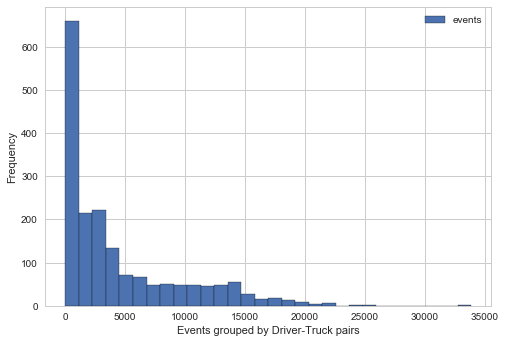

In [29]:
sns.set_style('whitegrid')
plt.rcParams["patch.force_edgecolor"] = True
dt_sizes[dt_sizes.events > 20].plot(kind='hist', bins=30)
plt.xlabel('Events grouped by Driver-Truck pairs')
plt.show()

In [30]:
dt_sizes.head(50).sort_index()

,,events
DriverID,EquipmentID,
ADAR,1950,18387
ANTR,1721,20956
ARCM,307,18415
BALD,1991,19249
BINA,1961,17271
BROD03,1941,22014
BUFB,1799,18922
BULR,1639,17809
BYRCHR,1734,18425


### Sample data for specific drivers

In [30]:
sample_drivers = ['EDWTI', 'CRES']
sample_trucks = ['2014', '1772']
events_col_list = ['EventTimeStamp', 'Odometer', 'TankLevelPercent', 'IgnitionStatus', 'EFReportReason',
                   'Speed',  'TankLevelGallons', 'Latitude', 'Longitude', 'LocationTimeStamp',
                  'tankcap', 'EquipmentID', 'DriverID']
sample_bool_series = np.logical_and(events_levels_df.DriverID.isin(sample_drivers), 
                                   events_levels_df.EquipmentID.isin(sample_trucks))
drivers_events = events_levels_df[sample_bool_series].loc[:, events_col_list].set_index(
    'EventTimeStamp', drop=False).sort_index()


In [ ]:
#drivers_events.loc['2017-01-12 05:56': '2017-01-12 12:15']

In [31]:
trans_col_list = ['tr_datetime', 'tr_id' 'tr_item_cd1', 'tr_item_qty1', 'tr_station_id', 
                  'tr_station_name','tr_station_cty', 'tr_station_st', 'tr_drvr_code', 'tr_unit_id'] 

sample_tran_bool_series = np.logical_and(fuel_trans_df.tr_drvr_code.isin(sample_drivers), 
                                   fuel_trans_df.tr_unit_id.isin(sample_trucks))
drivers_trans = fuel_trans_df[sample_tran_bool_series].loc[:, trans_col_list].sort_values(['tr_datetime'])

In [32]:
drivers_trans[:4]

,tr_datetime,tr_item_cd1,tr_item_qty1,tr_station_id,tr_station_name,tr_station_cty,tr_station_st,tr_drvr_code,tr_unit_id
3625,2017-01-12 06:10:00,ULSD,138.0,231060,FJ-CARLISLE 708,CARLISLE,PA,EDWTI,2014
4034,2017-01-13 06:00:00,SCLE,1.0,516089,PILOT 179,HAGERSTOWN,MD,EDWTI,2014
4154,2017-01-13 10:55:00,ULSD,102.0,231846,FJ-MAX MEADOWS 750,FORT CHISWELL,VA,EDWTI,2014
4447,2017-01-14 09:19:00,SCLE,1.0,516127,PILOT MIDDLESBORO 240,MIDDLESBORO,KY,EDWTI,2014


#### Filter to only fuel item codes, set index to transaction time, then order index

In [91]:
drivers_fuel_trans = drivers_trans[drivers_trans.tr_item_cd1.isin(act_fuel_transactions)].set_index('tr_datetime', drop=False).sort_index()
drivers_fuel_trans['next_tr_datetime'] = drivers_fuel_trans.tr_datetime.shift(-1)
print(drivers_fuel_trans.tr_datetime[1])
print(drivers_fuel_trans.tr_datetime[0])
print(drivers_fuel_trans.head())

2017-01-13 10:55:00
2017-01-12 06:10:00
                            tr_datetime tr_item_cd1  tr_item_qty1  \
tr_datetime                                                         
2017-01-12 06:10:00 2017-01-12 06:10:00        ULSD    138.000000   
2017-01-13 10:55:00 2017-01-13 10:55:00        ULSD    102.000000   
2017-01-15 10:03:00 2017-01-15 10:03:00        ULSD    125.000000   
2017-01-18 08:07:00 2017-01-18 08:07:00        ULSD    142.000000   
2017-01-20 04:19:00 2017-01-20 04:19:00        ULSD    130.009995   

                    tr_station_id       tr_station_name tr_station_cty  \
tr_datetime                                                              
2017-01-12 06:10:00        231060       FJ-CARLISLE 708       CARLISLE   
2017-01-13 10:55:00        231846    FJ-MAX MEADOWS 750  FORT CHISWELL   
2017-01-15 10:03:00        515984     PILOT SEVILLE 013        SEVILLE   
2017-01-18 08:07:00        516271  PILOT WHITE PINE 412     WHITE PINE   
2017-01-20 04:19:00        51625

In [34]:
event_keys = drivers_events[['EventTimeStamp','EquipmentID', 'DriverID']].drop_duplicates()
event_keys['prev_event_ts'] = event_keys.EventTimeStamp.shift(1)
print(event_keys.head())

                                 EventTimeStamp EquipmentID DriverID
EventTimeStamp                                                      
2017-01-07 17:28:16.870 2017-01-07 17:28:16.870        2014    EDWTI
2017-01-07 17:43:26.870 2017-01-07 17:43:26.870        2014    EDWTI
2017-01-07 17:58:26.980 2017-01-07 17:58:26.980        2014    EDWTI
2017-01-07 18:13:26.997 2017-01-07 18:13:26.997        2014    EDWTI
2017-01-07 18:28:27.043 2017-01-07 18:28:27.043        2014    EDWTI


In [35]:
print('drivers_events length is: ' + str(drivers_events.shape[0]))
print('event_keys length is: ' + str(event_keys.shape[0]))
print('drivers_fuel_trans length is: ' + str(drivers_fuel_trans.shape[0]))
print('unique tr_datetimes for driver : ' + str(len(drivers_fuel_trans.tr_datetime.unique())))

drivers_events length is: 20294
event_keys length is: 19327
drivers_fuel_trans length is: 210
unique tr_datetimes for driver : 210


In [44]:
print(event_keys.reindex(drivers_fuel_trans.index, method = 'nearest').head(3))
print(event_keys.reindex(drivers_fuel_trans.index, method = 'nearest').shift(1).head(3))

                             EventTimeStamp EquipmentID DriverID
tr_datetime                                                     
2017-01-12 06:10:00 2017-01-12 06:12:31.797        2014    EDWTI
2017-01-13 10:55:00 2017-01-13 10:58:16.083        2014    EDWTI
2017-01-15 10:03:00 2017-01-15 10:08:26.700        2014    EDWTI
                             EventTimeStamp EquipmentID DriverID
tr_datetime                                                     
2017-01-12 06:10:00                     NaT         NaN      NaN
2017-01-13 10:55:00 2017-01-12 06:12:31.797        2014    EDWTI
2017-01-15 10:03:00 2017-01-13 10:58:16.083        2014    EDWTI


In [92]:
#event_keys.reindex(drivers_fuel_trans.index, method = 'nearest')
drivers_event_trans_keys = drivers_fuel_trans[['tr_datetime', 'next_tr_datetime', 'tr_drvr_code', 'tr_unit_id']].reindex(
    event_keys.index, method = 'nearest').sort_index()
drivers_event_trans_keys['EventTimeStamp'] = drivers_event_trans_keys.index.values
drivers_event_trans_keys.loc['2017-01-12 05:53' : '2017-01-12 06:17']


,tr_datetime,next_tr_datetime,tr_drvr_code,tr_unit_id,EventTimeStamp
EventTimeStamp,,,,,
2017-01-12 05:53:01.767,2017-01-12 06:10:00,2017-01-13 10:55:00,EDWTI,2014,2017-01-12 05:53:01.767
2017-01-12 05:55:11.767,2017-01-12 06:10:00,2017-01-13 10:55:00,EDWTI,2014,2017-01-12 05:55:11.767
2017-01-12 05:56:31.780,2017-01-12 06:10:00,2017-01-13 10:55:00,EDWTI,2014,2017-01-12 05:56:31.780
2017-01-12 06:12:31.797,2017-01-12 06:10:00,2017-01-13 10:55:00,EDWTI,2014,2017-01-12 06:12:31.797
2017-01-12 06:16:01.797,2017-01-12 06:10:00,2017-01-13 10:55:00,EDWTI,2014,2017-01-12 06:16:01.797


In [54]:
drivers_event_trans_keys.head()

,tr_datetime,prev_tr_datetime,tr_drvr_code,tr_unit_id,EventTimeStamp
EventTimeStamp,,,,,
2017-01-07 17:28:16.870,2017-01-12 06:10:00,2017-01-13 10:55:00,EDWTI,2014,2017-01-07 17:28:16.870
2017-01-07 17:43:26.870,2017-01-12 06:10:00,2017-01-13 10:55:00,EDWTI,2014,2017-01-07 17:43:26.870
2017-01-07 17:58:26.980,2017-01-12 06:10:00,2017-01-13 10:55:00,EDWTI,2014,2017-01-07 17:58:26.980
2017-01-07 18:13:26.997,2017-01-12 06:10:00,2017-01-13 10:55:00,EDWTI,2014,2017-01-07 18:13:26.997
2017-01-07 18:28:27.043,2017-01-12 06:10:00,2017-01-13 10:55:00,EDWTI,2014,2017-01-07 18:28:27.043


### Approach 1: Intervals between transactions 


### Approach 2: Max Odometer between transaction timestamps
#### Outlier odometer readings: Use diff method for decreases in odometer 
-Only keep rows that are temporally adjacent to fuel 
- downsample events to minutes
-- 